<a href="https://colab.research.google.com/github/AdeelH/tl-experiments/blob/master/TL_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 experiment

The purpose of this experiment is to study the problem of generalizing a model pretrained on `n`-band data to `m`-band data, where `m > n`. This is relevant for adapting a model pretrained on RGB images to multi-band satellite imagery. Here we simulate this problem using only the RGB channels.

This experiment involves training 3 models:

    1. RGB model: a model trained on all 3 RGB channels
    2. R-only model: a model trained on only the R channel
    3. Augmented model: a modified form of the R-only model (after it has been trained) that accepts all 3 channels
    
The expectation is that `(1)` and `(3)` will achieve similar performance, while `(2)` will be slightly worse. It is also expected that `(3)` will reach high performance faster than `(1)`.

In [0]:
!nvidia-smi

Mon Jul  8 14:00:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils
import torchvision as tv
from torchvision import transforms as tf

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data

Define transforms to be applied to the data. 

For training, we augment the data with random crops and random horizontal flips. We also normalize the images using the mean and std dev of cifar images.

In [0]:
transform = tf.Compose([
    tf.RandomCrop(32, padding=4),
    tf.RandomHorizontalFlip(p=0.5),
    tf.ToTensor(),
    tf.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = tf.Compose([
    tf.ToTensor(),
    tf.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

The CIFAR10 dataset can be downloaded using `torchvision`.  `tv.datasets.CIFAR10()` returns a `torchvision.VisionDataset` object. We'll use the test set for validation.

In [0]:
class_names = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
])

# dataset without any transformations for displaying untransformed images
cifar = tv.datasets.CIFAR10(root='./data/cifar/', train=False, download=True)

train = tv.datasets.CIFAR10(root='./data/cifar/', train=True, download=True, transform=transform)
val = tv.datasets.CIFAR10(root='./data/cifar/', train=False, download=True, transform=transform_test)

0it [00:00, ?it/s]

170500096it [00:06, 26879370.78it/s]                               


Files already downloaded and verified
Files already downloaded and verified


Set random seed for reproducibility.

In [0]:
torch.manual_seed(0)

# RGB Model

## Definition

Define a simple classification model that takes in a base model as an input and sets its final layer to a Linear layer of appropriate size. 

If the `r_only` flag is turned on, this module uses only the first channel of the input (which would presumably be the red channel). It does this by setting the other channels to zero.

In [0]:
class ClfModel(nn.Module):

    def __init__(self, params, r_only=False):
        super(ClfModel, self).__init__()

        self.r_only = r_only
        self.net = params['base_model']
        self.net.fc = nn.Linear(self.net.fc.in_features, params['nclasses'])

    def forward(self, X):
        if self.r_only:
            X[:, 1:, :, :] = 0
        out = self.net(X)
        return out


## Create model

Use the Resnet18 that is available in `torchvision.models` as the base model. We will not use the pretrained weights; instead, we are going to modify the network slightly and train from scratch.

In [0]:
model_params = {}
model_params['base_model'] = tv.models.resnet18(pretrained=False).cuda()
model_params['nclasses'] = 10

Let us first train the model on all 3 channels so that we have a reference to compare against.

In [0]:
model_RGB = ClfModel(model_params, r_only=False).cuda()
model_RGB

ClfModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

## Modify

The first convolutional layer of the torchvision Resnet has a kernel size of 7x7 and is designed for ImageNet-like images. Since CIFAR10 images are much smaller (only 32x32), it makes sense to use a smaller kernel. So we replace the first conv layer with a 3x3 conv layer.

We also remove the first maxpool layer, to avoid downsampling the already small CIFAR images.

(This is in line with the CIFAR experiments in the Resnet paper)

In [0]:
model_RGB.net._modules['conv1'] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).cuda()
model_RGB.net._modules['maxpool'] = nn.Identity().cuda()
model_RGB

ClfModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64

## (Optional) Load pretrained model weights from file

In [0]:
def load_weights(model_save_name, model):
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    path = F"/content/gdrive/My Drive/{model_save_name}"
    state = torch.load(path)
    print(state['info'])
    model.load_state_dict(state['model'])

load_weights('resnet18_rgb_3x3', model_RGB)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
{'acc': tensor(0.9324), 'epoch': 49, 'val_loss': tensor(4.9306), 'lr': 0.01008879722072778}


# Training

Define a function for saving models to file during training. We do this by mounting Google Drive to `/content/`. This requires authentication.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

def save_model(model, name, info={}):
    state = {
        'model': model.state_dict(),
        'info': info
    }
    path = F"/content/gdrive/My Drive/{name}" 
    torch.save(state, path)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Define training loop

In [0]:
import time

    
def validate(model, criterion, val_dl):
    
    val_loss = 0.
    val_corrects = 0
    model.eval()
    
    with torch.no_grad():
        for i, (batch, labels) in enumerate(val_dl):
            N = batch.shape[0]
            batch = batch.cuda()

            preds = model(batch).detach().cpu()
            val_loss += criterion(preds, labels)
            val_corrects += (preds.argmax(dim=-1) == labels).detach().cpu().float().sum()

    val_acc = val_corrects.float() / len(val_dl.sampler)
    return val_loss, val_acc


def train_epoch(model, train_dl, criterion, optimizer):
    
    epoch_loss = 0.
    train_corrects = 0

    model.train()
    for i, (batch, labels) in enumerate(train_dl):
        N = batch.shape[0]
        batch = batch.cuda()
        labels = labels.cuda()

        preds = model(batch)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach().cpu()
        train_corrects += (preds.argmax(dim=-1) == labels).detach().cpu().float().sum()

    train_acc = train_corrects.float() / len(train_dl.sampler)
    return epoch_loss, train_acc


def train_clf(model, train_dl, val_dl, optimizer, sched, params, criterion=nn.CrossEntropyLoss(), callback=lambda x: None, save_name='model', best_acc=0.85):
    '''Train a classification model.
    
    Args:
        - model: The model to be trained (must be a `nn.Module`).
        - train_dl: A `torch.utils.data.Dataloader` for training data.
        - val_dl: A `torch.utils.data.Dataloader` for validation data.
        - optimizer: The optimizer to use for training.
        - sched: The LR scheduler to use for training. `sched.step()` will be called after each epoch.
        - params: Additional training parameters.
        - criterion: Loss function.
        - callback: A callback that is called at the end of each epoch.
        - save_name: Filename to use for saving the model.
        - best_acc: Initial value for best-accuracy-so-far.
    '''

    torch.cuda.empty_cache()
    for epoch in range(params['epochs']):
        
        start_time = time.time()

        # train (fwd pass and backprop)
        epoch_loss, train_acc = train_epoch(model, train_dl, criterion, optimizer)

        # validate
        val_loss, val_acc = validate(model, criterion, val_dl)

        # save best model so far
        # save only if there is an improvement of >=0.05%
        if val_acc >= (best_acc + 0.005):
            best_acc = val_acc
            info = {'acc': val_acc, 'epoch': epoch, 'val_loss': val_loss, 'lr': optimizer.param_groups[0]['lr']}
            save_model(model, save_name, info=info)

        print('epoch: %3d, lr: %0.8f, epoch_loss: %4.4f, val_loss: %4.4f, train_acc: %0.4f, val_acc: %0.4f, best: %0.4f, time: %0.1f' % (epoch, optimizer.param_groups[0]['lr'], epoch_loss, val_loss, train_acc, val_acc, best_acc, time.time() - start_time))
        sched.step()
        callback(model)


## Train

In [0]:
train_params = {}
train_params['epochs'] = 50
train_params['batch_size'] = 128
train_params['val_batch_size'] = 512
train_params['learning_rate'] = 1e-1

train_params['model_save_name'] = 'resnet18_rgb_3x3'


In [0]:
train_dl = torch.utils.data.DataLoader(train, batch_size=train_params['batch_size'], pin_memory=False, num_workers=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val, batch_size=train_params['val_batch_size'], pin_memory=False, num_workers=4)

In [0]:
optimizer = optim.SGD(model_RGB.parameters(), lr=train_params['learning_rate'], momentum=0.9, weight_decay=5e-4)

sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, train_params['epochs'], eta_min=train_params['learning_rate'] / 10)

train_clf(model_RGB, train_dl, val_dl, optimizer, sched, train_params, save_name=train_params['model_save_name'])


epoch:   0, lr: 0.10000000, epoch_loss: 420.3582, val_loss: 21.2343, train_acc: 0.6120, val_acc: 0.6292, best: 0.8500, time: 68.4
epoch:   1, lr: 0.09991120, epoch_loss: 356.4074, val_loss: 17.7188, train_acc: 0.6734, val_acc: 0.6893, best: 0.8500, time: 69.3
epoch:   2, lr: 0.09964516, epoch_loss: 302.6281, val_loss: 15.1427, train_acc: 0.7286, val_acc: 0.7366, best: 0.8500, time: 70.4
epoch:   3, lr: 0.09920293, epoch_loss: 261.1299, val_loss: 15.2427, train_acc: 0.7656, val_acc: 0.7348, best: 0.8500, time: 71.1
epoch:   4, lr: 0.09858624, epoch_loss: 236.1884, val_loss: 15.3667, train_acc: 0.7901, val_acc: 0.7483, best: 0.8500, time: 71.4
epoch:   5, lr: 0.09779754, epoch_loss: 218.8011, val_loss: 11.7551, train_acc: 0.8063, val_acc: 0.7978, best: 0.8500, time: 71.8
epoch:   6, lr: 0.09683994, epoch_loss: 203.3820, val_loss: 17.6739, train_acc: 0.8205, val_acc: 0.7082, best: 0.8500, time: 71.7
epoch:   7, lr: 0.09571722, epoch_loss: 192.8132, val_loss: 11.7081, train_acc: 0.8313, va

## Visualize first conv layer filters

`torchvision.utils.make_grid()` is makes it easy to create a grid from the convolutional filters, which can then be plotted.

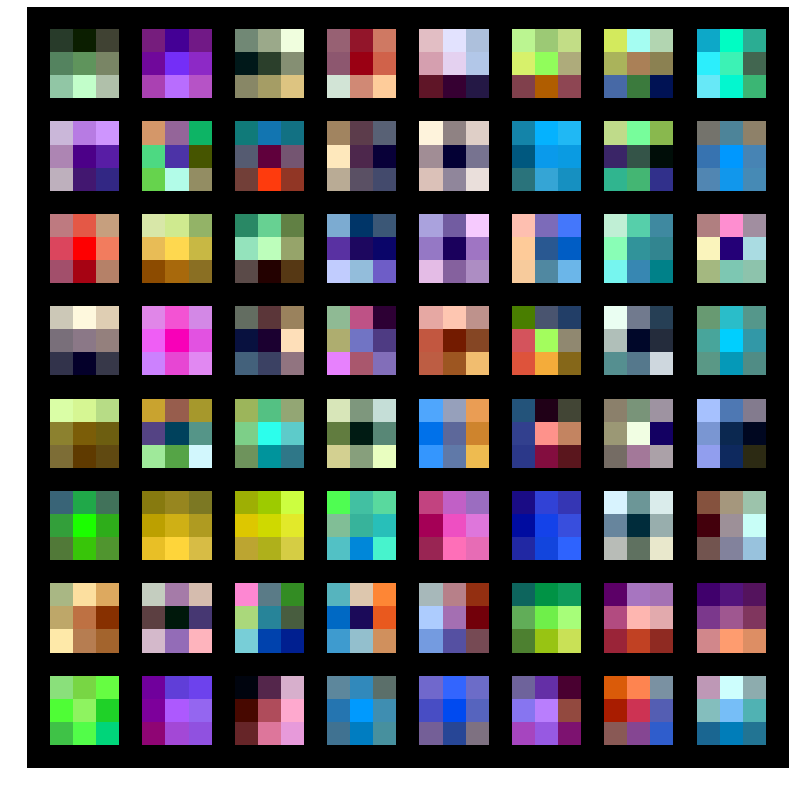

In [0]:
def viz_filters(conv_layer, scale_each=True):
    fs = conv_layer.weight.data.clone().detach().cpu()
    grid = tv.utils.make_grid(fs, normalize=True, scale_each=scale_each, padding=1).permute(1, 2, 0)

    plt.figure(figsize=(14, 14))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
    
viz_filters(model_RGB.net._modules['conv1'], scale_each=True)

## Visualize outputs of all intermediate conv layers


------------------------------------------- Input image -------------------------------------------



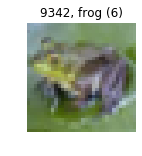

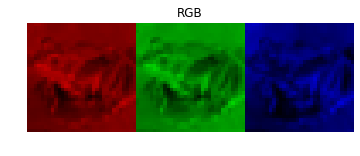


------------------------------------------- Model predictions -------------------------------------------

Predicted class probabilities: tensor([1.5753e-05, 3.6507e-05, 9.1521e-06, 1.4632e-05, 2.0006e-05, 1.6011e-05,
        9.9982e-01, 3.0605e-05, 3.1529e-05, 9.3891e-06])


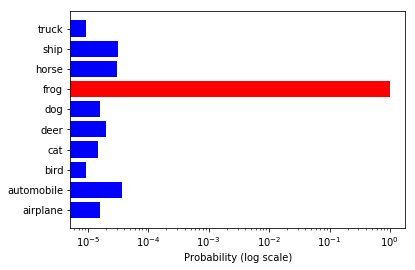


------------------------------------------- Layer-wise output -------------------------------------------

Layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output shape: torch.Size([64, 1, 32, 32])


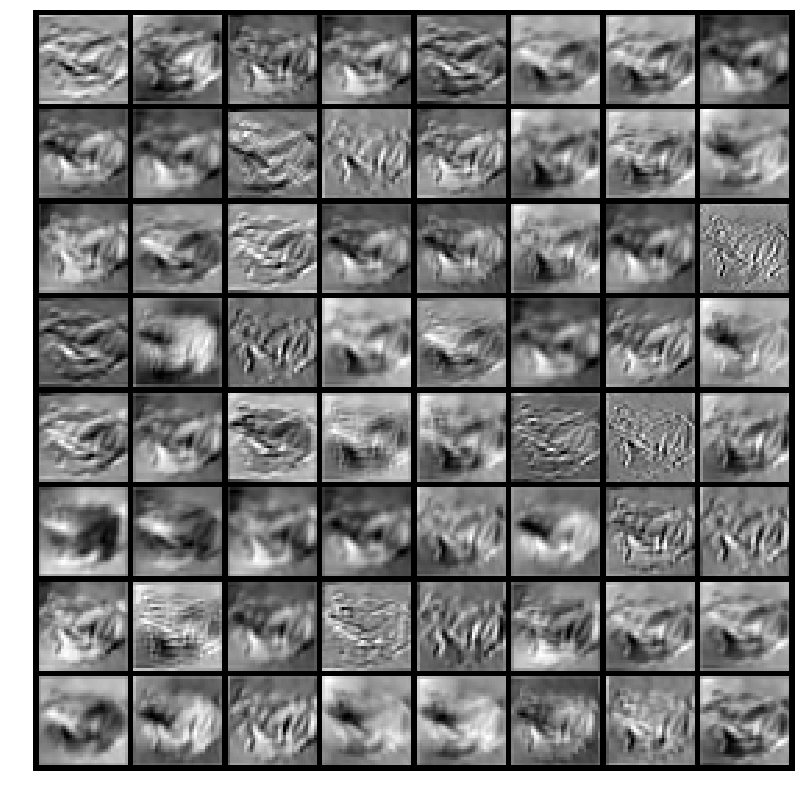

Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([64, 1, 32, 32])


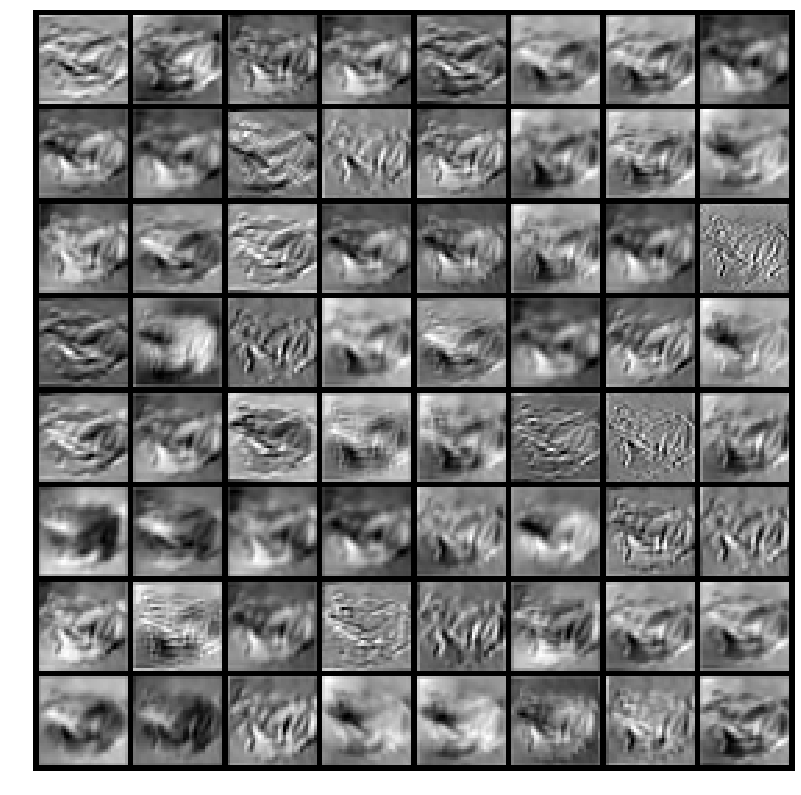

Layer: ReLU(inplace)
Output shape: torch.Size([64, 1, 32, 32])


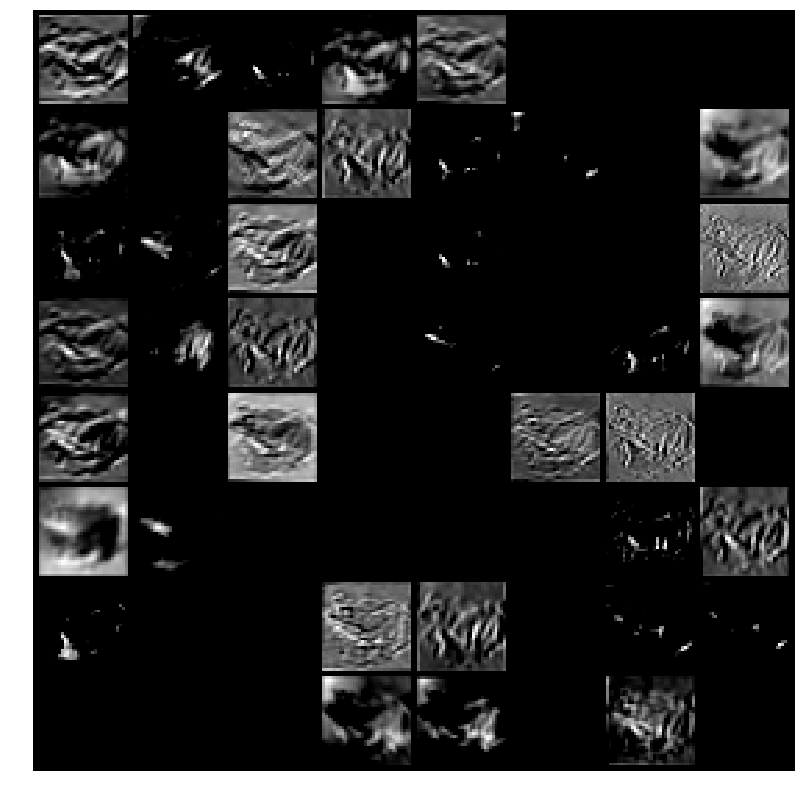

Layer: Identity()
Output shape: torch.Size([64, 1, 32, 32])


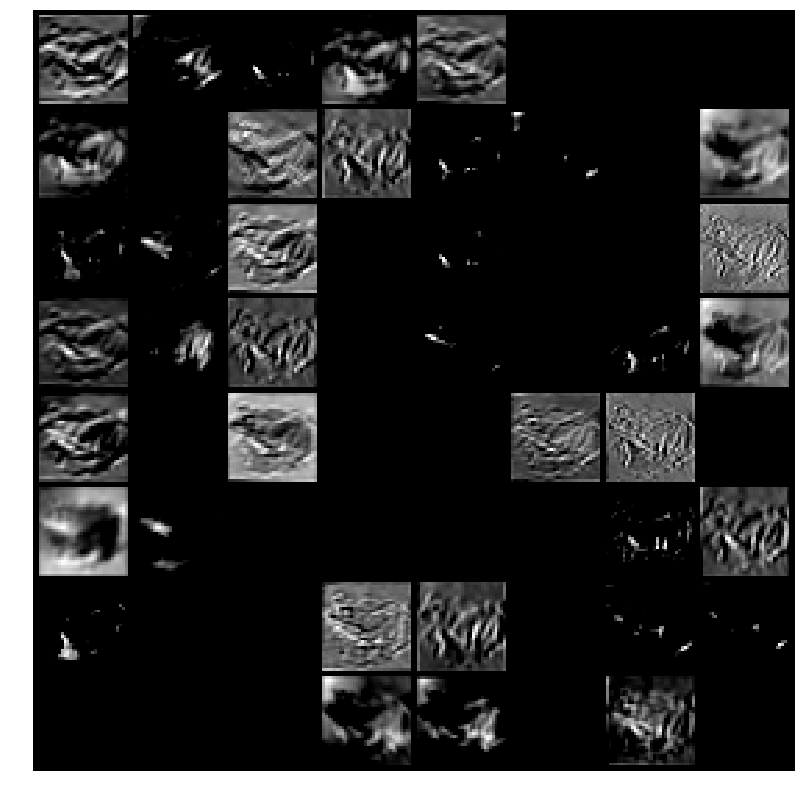

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Output shape: torch.Size([64, 1, 32, 32])


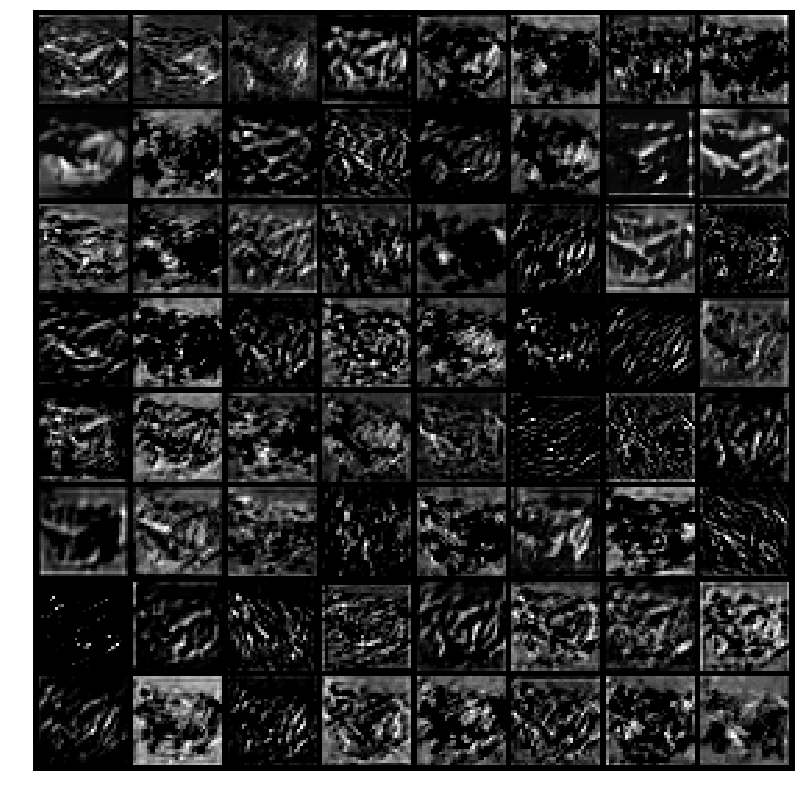

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05,

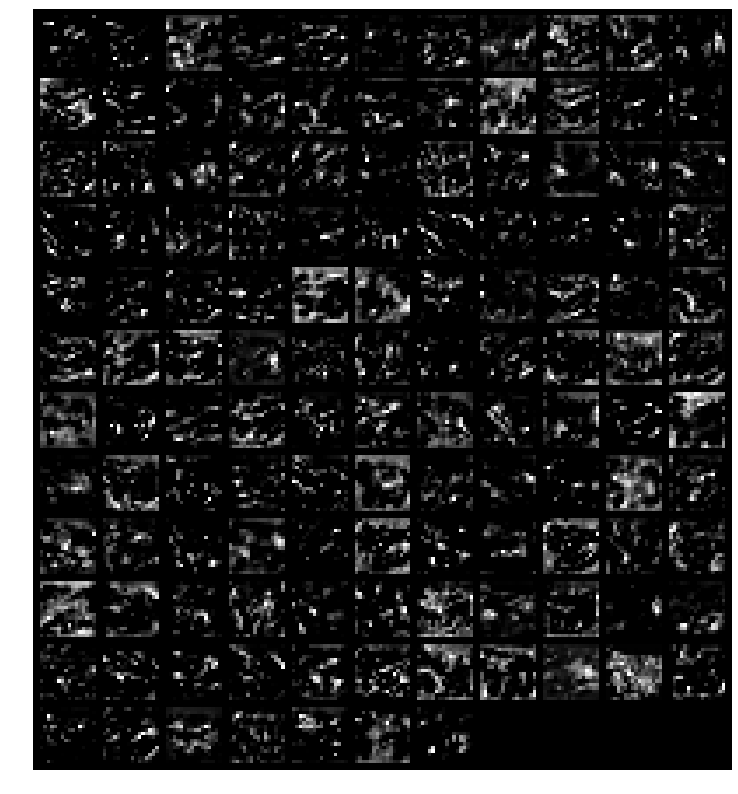

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-0

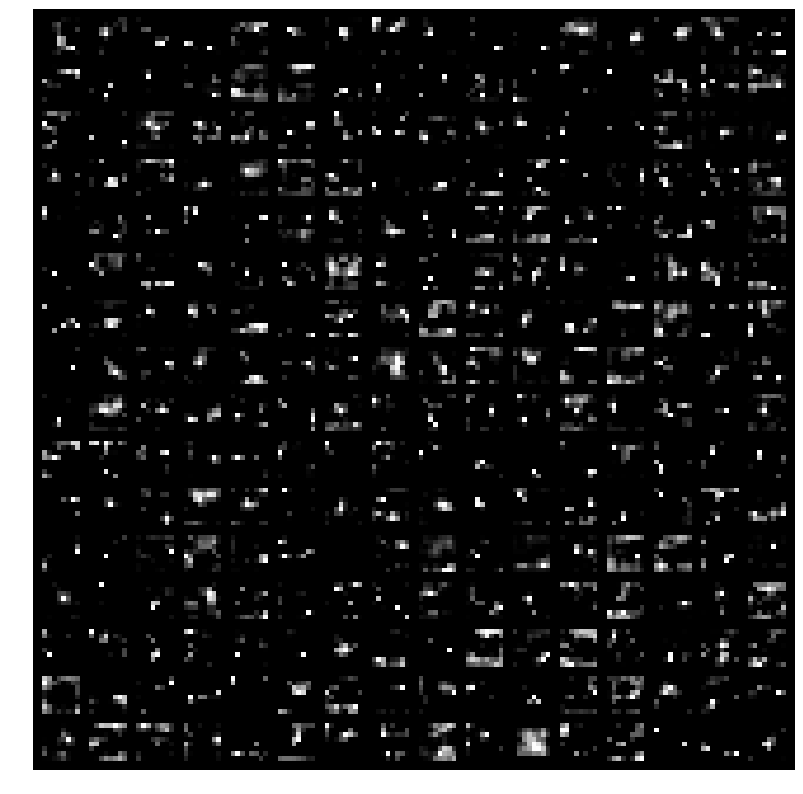

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-0

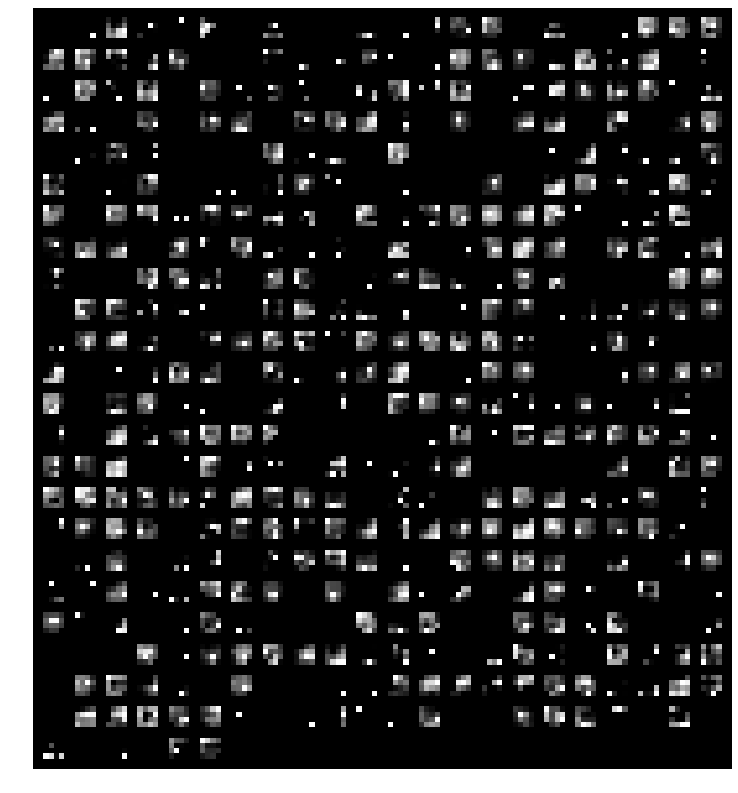

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Layer: AdaptiveAvgPool2d(output_size=(1, 1))
Output shape: torch.Size([512, 1, 1, 1])


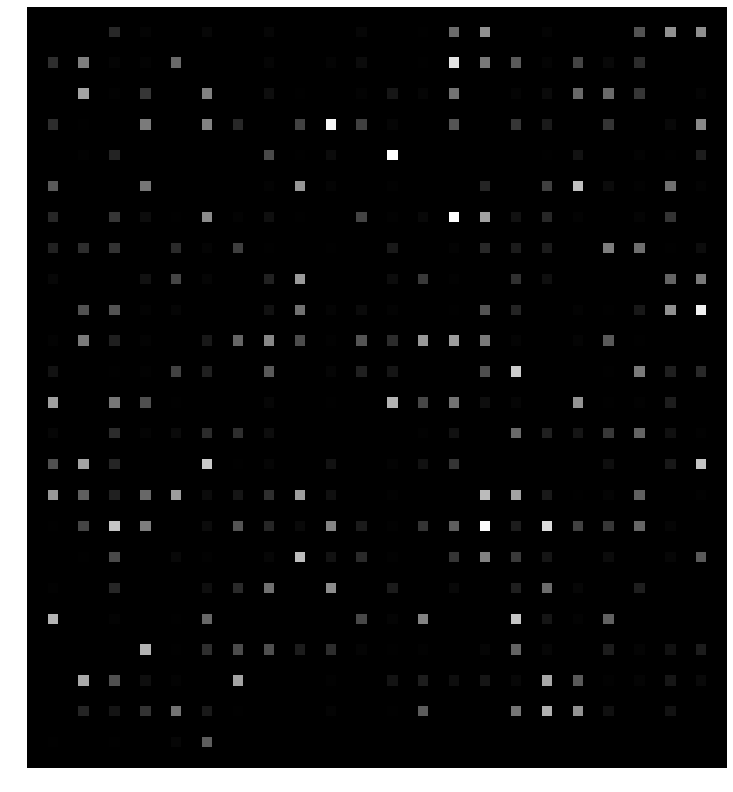

In [99]:
import itertools

def model_debug(model, val_idx, flatten_seqs=False):

    im, label = cifar[val_idx]
    im = np.array(im)

    print('\n------------------------------------------- Input image -------------------------------------------\n')
    plt.figure(figsize=(2, 2))
    plt.imshow(im)
    plt.title(f'{idx}, {class_names[label]} ({label})')
    plt.axis('off')
    plt.show()

    im_r, im_g, im_b = im.copy(), im.copy(), im.copy()
    im_r[..., [1, 2]] = 0
    im_g[..., [0, 2]] = 0
    im_b[..., [0, 1]] = 0
    plt.figure(figsize=(6, 2))
    plt.imshow(np.concatenate((im_r, im_g, im_b), axis=1))
    plt.title(f'RGB')
    plt.axis('off')
    plt.show()

    print('\n------------------------------------------- Model predictions -------------------------------------------\n')
    
    val_im = val[val_idx][0].unsqueeze(0).cuda()
    model.eval()
    with torch.no_grad():
        preds = F.softmax(model(val_im), dim=-1).detach().cpu().squeeze()
        print('Predicted class probabilities:', preds)
        cols = ['b'] * len(preds)
        cols[preds.argmax()] = 'r'
        plt.barh(class_names, preds, color=cols)
        plt.xscale('log')
        plt.xlabel('Probability (log scale)')
        plt.show()
        
        print('\n------------------------------------------- Layer-wise output -------------------------------------------\n')
        
        if flatten_seqs:
            layer_list = [list(l) if isinstance(l, nn.Sequential) else [l] for l in model.net.children()]
            layer_list = list(itertools.chain(*layer_list))
        else:
            layer_list = list(model.net.children())
            
        model_seq = nn.Sequential(*layer_list)
        for i in range(1, len(model_seq)):
            model_subset = model_seq[:i]
            model_subset.eval()
            fs = model_subset(val_im).detach().cpu().permute(1, 0, 2, 3)

            print('Layer:', model_subset[i - 1])
            print('Output shape:', fs.shape)
            
            normalize = not (fs.shape[-1] == 1 and fs.shape[-2] == 1)
            grid = tv.utils.make_grid(fs, nrow=int(len(fs)**0.5), normalize=normalize, scale_each=normalize, padding=2).permute(1, 2, 0)

            plt.figure(figsize=(14, 14))
            plt.imshow(grid, cmap='gray')
            plt.axis('off')
            plt.show()

idx = int(torch.rand(1) * len(val))
model_debug(model_RGB, idx)

# Red-only model

## Create

In [0]:
model_params['base_model'] = tv.models.resnet18(pretrained=False).cuda()

model_R = ClfModel(model_params, r_only=True).cuda()
model_R

ClfModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

## Modify

Same as the RGB model.

In [0]:
model_R.net._modules['conv1'] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).cuda()
model_R.net._modules['maxpool'] = nn.Identity().cuda()
model_R

ClfModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64

## (Optional) Load pretrained model weights from file

In [0]:
load_weights('resnet18_red_3x3', model_R)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
{'acc': tensor(0.9246), 'epoch': 93, 'val_loss': tensor(5.9798), 'lr': 0.0021921202840320055}


## Train

In [0]:
train_params = {}
train_params['epochs'] = 100
train_params['batch_size'] = 64
train_params['val_batch_size'] = 512
train_params['learning_rate'] = 1e-1
train_params['learning_rate_min'] = 1e-3

train_params['model_save_name'] = 'resnet18_red_3x3'


In [0]:
train_dl = torch.utils.data.DataLoader(train, batch_size=train_params['batch_size'], pin_memory=False, num_workers=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val, batch_size=train_params['val_batch_size'], pin_memory=False, num_workers=4)

In [0]:
optimizer = optim.SGD(model_R.parameters(), lr=train_params['learning_rate'], momentum=0.9, weight_decay=5e-4)

sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, train_params['epochs'], eta_min=train_params['learning_rate_min'])

train_clf(model_R, train_dl, val_dl, optimizer, sched, train_params, save_name=train_params['model_save_name'], best_acc=0.9)


epoch:   0, lr: 0.10000000, epoch_loss: 1570.6803, val_loss: 36.5199, train_acc: 0.2613, val_acc: 0.3629, best: 0.9000, time: 74.0
epoch:   1, lr: 0.09997557, epoch_loss: 999.5836, val_loss: 23.6784, train_acc: 0.5443, val_acc: 0.5997, best: 0.9000, time: 73.7
epoch:   2, lr: 0.09990232, epoch_loss: 760.7906, val_loss: 23.4957, train_acc: 0.6610, val_acc: 0.6059, best: 0.9000, time: 73.5
epoch:   3, lr: 0.09978032, epoch_loss: 655.8225, val_loss: 21.6781, train_acc: 0.7125, val_acc: 0.6464, best: 0.9000, time: 73.4
epoch:   4, lr: 0.09960968, epoch_loss: 600.4899, val_loss: 21.4450, train_acc: 0.7365, val_acc: 0.6459, best: 0.9000, time: 73.3
epoch:   5, lr: 0.09939057, epoch_loss: 568.4307, val_loss: 14.5426, train_acc: 0.7524, val_acc: 0.7555, best: 0.9000, time: 73.2
epoch:   6, lr: 0.09912322, epoch_loss: 541.1099, val_loss: 20.5832, train_acc: 0.7643, val_acc: 0.6797, best: 0.9000, time: 73.3
epoch:   7, lr: 0.09880788, epoch_loss: 517.9255, val_loss: 17.7318, train_acc: 0.7726, v

### Train some more

In [0]:
train_params = {}
train_params['epochs'] = 100
train_params['batch_size'] = 64
train_params['val_batch_size'] = 512
train_params['learning_rate'] = 1e-1
train_params['learning_rate_min'] = 1e-3

train_params['model_save_name'] = 'resnet18_red_3x3'


In [0]:
train_dl = torch.utils.data.DataLoader(train, batch_size=train_params['batch_size'], pin_memory=False, num_workers=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val, batch_size=train_params['val_batch_size'], pin_memory=False, num_workers=4)

In [0]:
optimizer = optim.SGD(model_R.parameters(), lr=train_params['learning_rate'], momentum=0.9, weight_decay=5e-4)

sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, train_params['epochs'], eta_min=train_params['learning_rate_min'])

train_clf(model_R, train_dl, val_dl, optimizer, sched, train_params, save_name=train_params['model_save_name'], best_acc=0.9)


## Visualize first conv layer filters


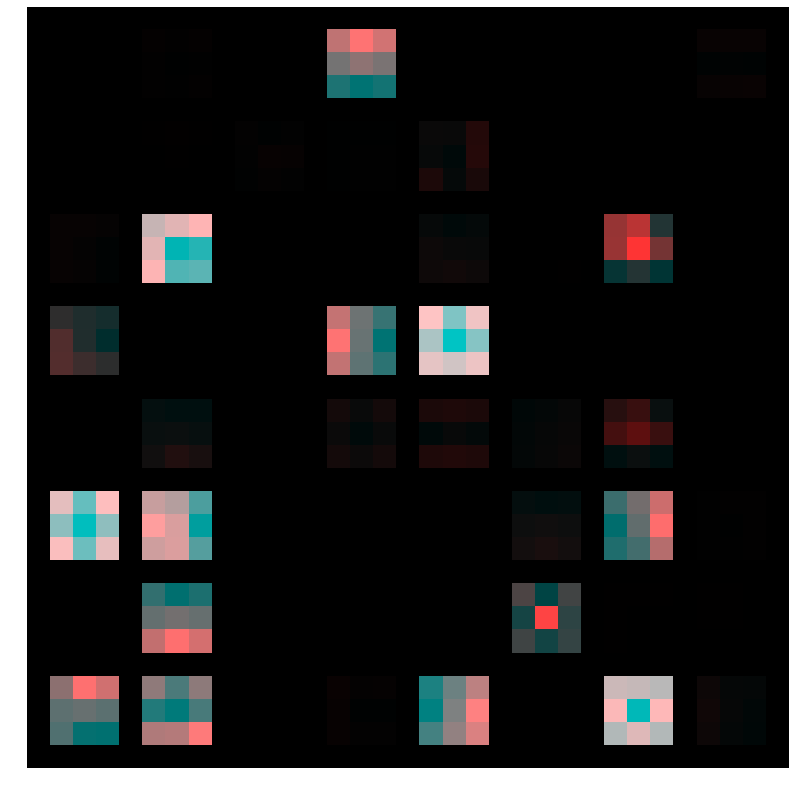

In [0]:
viz_filters(model_R.net._modules['conv1'])

## Visualize outputs of all intermediate conv layers


------------------------------------------- Input image -------------------------------------------



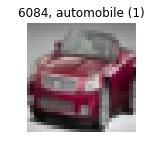

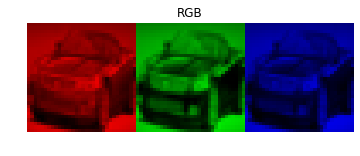


------------------------------------------- Model predictions -------------------------------------------

Predicted class probabilities: tensor([2.0754e-07, 9.9994e-01, 1.0791e-06, 2.3674e-06, 5.5555e-07, 3.2686e-06,
        1.3262e-05, 3.6017e-06, 2.2120e-05, 1.3653e-05])


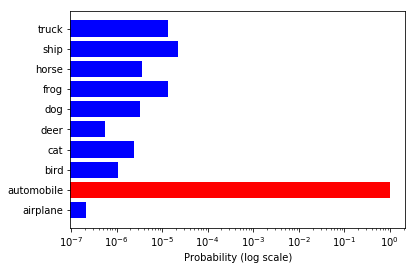



------------------------------------------- Layer-wise output -------------------------------------------

Layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output shape: torch.Size([64, 1, 32, 32])


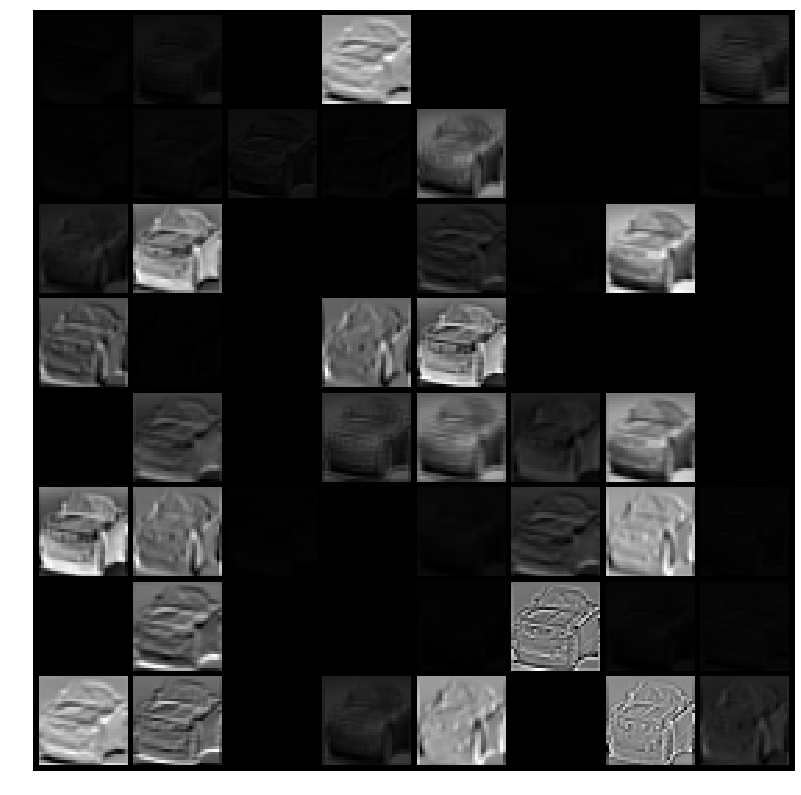

Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([64, 1, 32, 32])


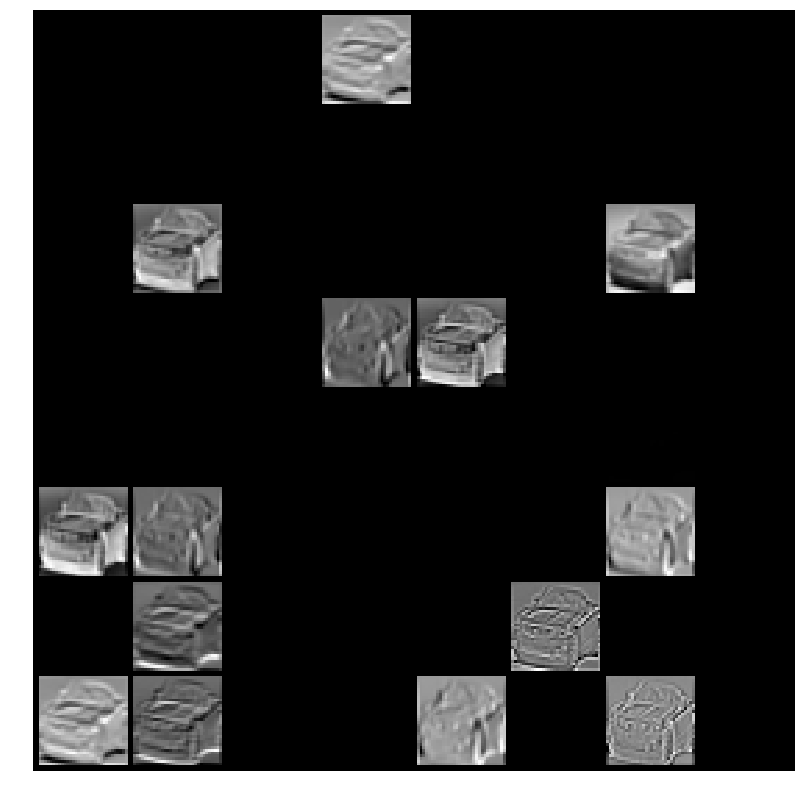

Layer: ReLU(inplace)
Output shape: torch.Size([64, 1, 32, 32])


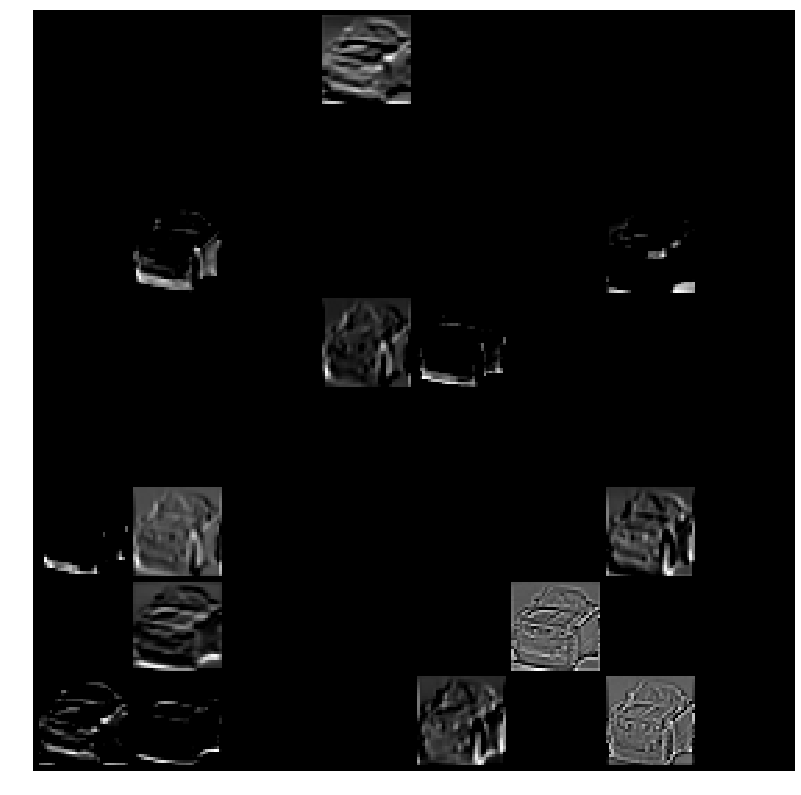

Layer: Identity()
Output shape: torch.Size([64, 1, 32, 32])


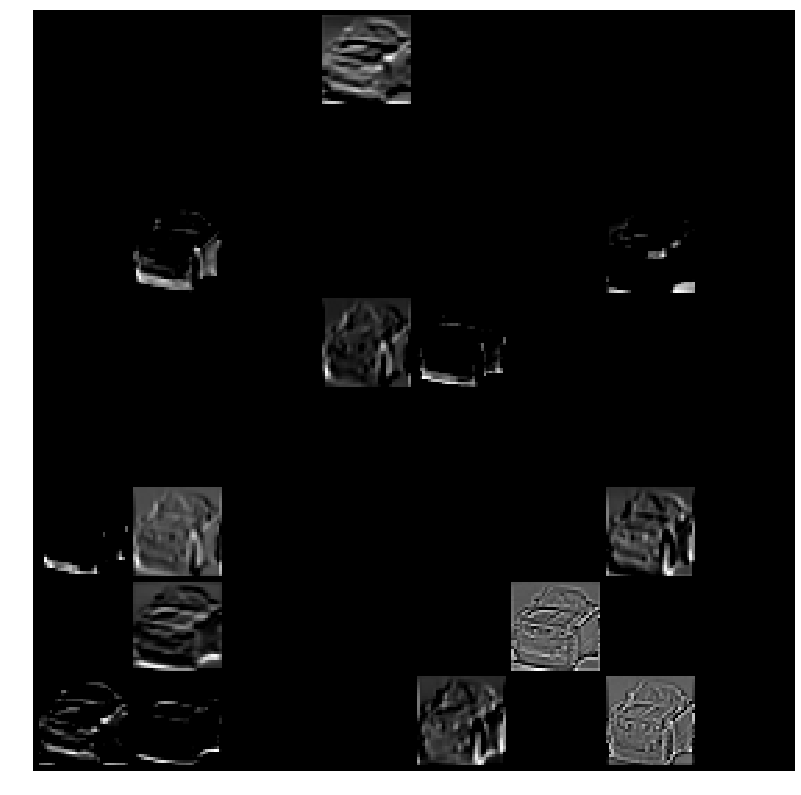

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Output shape: torch.Size([64, 1, 32, 32])


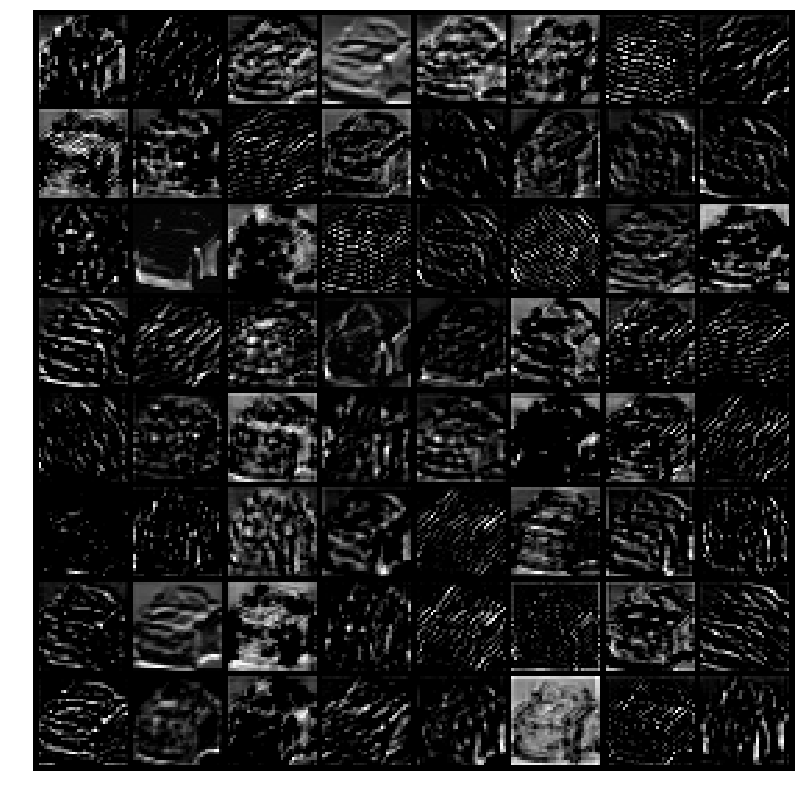

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05,

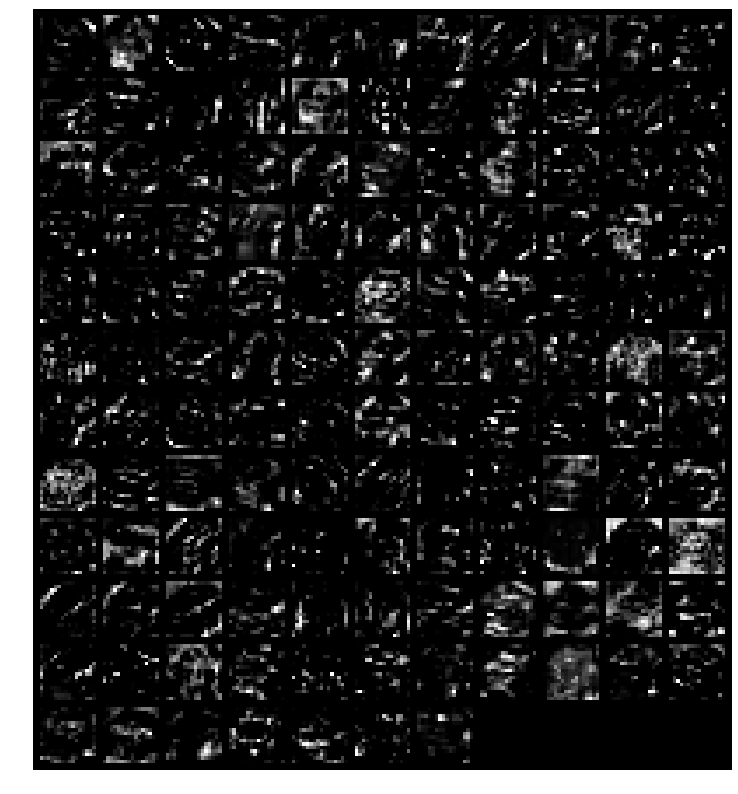

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-0

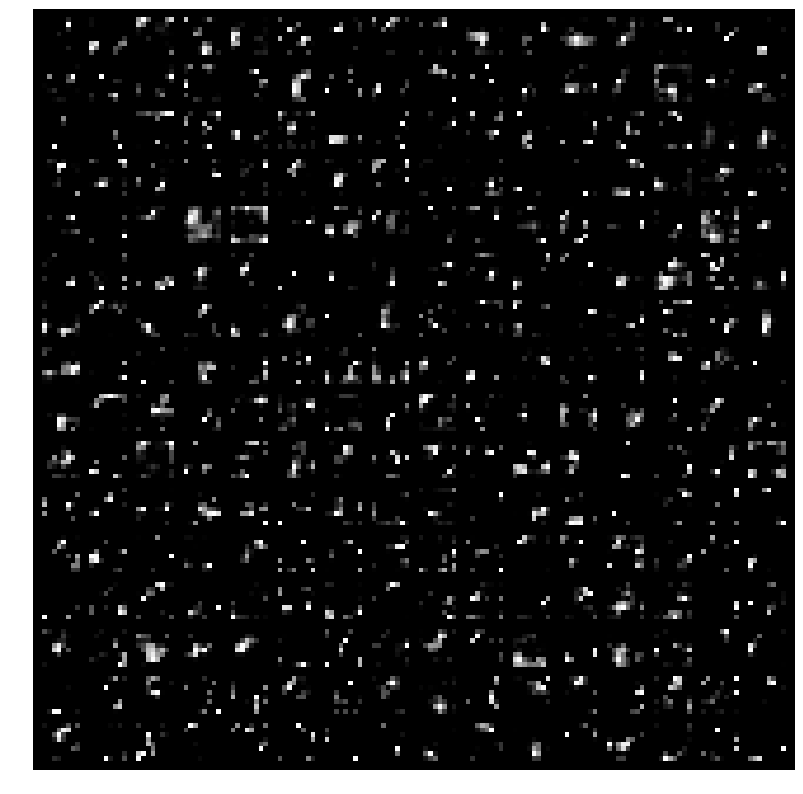

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-0

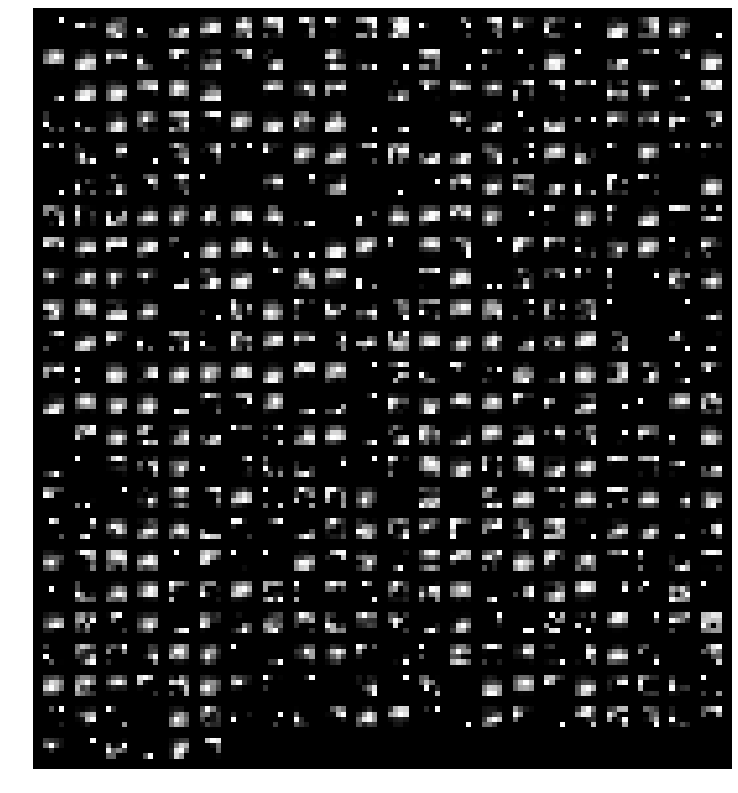

In [0]:
idx = int(torch.rand(1) * len(val))
model_debug(model_R, idx)

# Augmented model

We will now modify the red-only model to create an augmented model that will take in all 3 color channels. We will train this model on all 3 channels, with the hope that it achieves performace equal to the RGB model, but more quickly since it already knows how to work with the red channel.

The modification is as follows.

**Original model**:

```
                input
                  |
                  |
              conv layer
              (red only)
                  |
                  |
          <rest of the model>

```


**Augmented model**:

```
                 input
                   |
                   |    ModifiedConv1
    ---------------|----------------
    |             / \              |
    |           /     \            |
    |         /         \          |
    | conv layer        conv layer |
    | (red only)          (rgb)    |
    |          \       /           |
    |           \     /            |
    |            \   /             |
    |            concat            |
    |              |               |
    |              |               |
    |        1x1 conv layer        |
    ---------------|----------------
                   |
                   |
           <rest of the model>

```

In [0]:
class ModifiedConv1(nn.Module):
  
  def __init__(self, conv1):
    super(ModifiedConv1, self).__init__()
    
    self.original_conv1 = conv1
    self.new_conv1 = copy.deepcopy(conv1)
    self.after = nn.Sequential(
        nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False)
    )
    # init weights for new conv layer
    torch.nn.init.xavier_uniform_(self.new_conv1.weight.data)
    

  def forward(self, rgb):
    r_only = rgb.clone()
    r_only[:, 1:, :, :] = 0
    
    r_out = self.original_conv1(r_only)
    rgb_out = self.new_conv1(rgb)
    concatenated = torch.cat((r_out, rgb_out), dim=1)
    
    out = self.after(concatenated)
    
    return out


In [0]:
import copy

class AugmentedResnet(nn.Module):
  
    def __init__(self, params):
        super(AugmentedResnet, self).__init__()

        self.net = copy.deepcopy(params['base_model'].net)
        self.net._modules['conv1'] = ModifiedConv1(self.net._modules['conv1'])

    def forward(self, X):
        out = self.net(X)
        return out


## Create

In [0]:
model_aug_params = {}
model_aug_params['base_model'] = model_R

model_aug = AugmentedResnet(model_aug_params).cuda()
model_aug

AugmentedResnet(
  (net): ResNet(
    (conv1): ModifiedConv1(
      (original_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (new_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (after): Sequential(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

## (Optional) Load pretrained model weights from file

In [0]:
load_weights('resnet18_aug_3x3', model_aug)

## Train

In [0]:
train_params = {}
train_params['epochs'] = 50
train_params['batch_size'] = 128
train_params['val_batch_size'] = 512
train_params['learning_rate'] = 1e-1
train_params['learning_rate_min'] = 1e-3

train_params['model_save_name'] = 'resnet18_aug_3x3'


In [0]:
train_dl = torch.utils.data.DataLoader(train, batch_size=train_params['batch_size'], pin_memory=False, num_workers=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val, batch_size=train_params['val_batch_size'], pin_memory=False, num_workers=4)

In [45]:
optimizer = optim.SGD(model_aug.parameters(), lr=train_params['learning_rate'], momentum=0.9, weight_decay=5e-4)

sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, train_params['epochs'], eta_min=train_params['learning_rate_min'])

train_clf(model_aug, train_dl, val_dl, optimizer, sched, train_params, save_name=train_params['model_save_name'], best_acc=0.9)


epoch:   0, lr: 0.10000000, epoch_loss: 452.1363, val_loss: 21.0592, train_acc: 0.5874, val_acc: 0.6460, best: 0.9000, time: 195.9
epoch:   1, lr: 0.09990232, epoch_loss: 275.7016, val_loss: 16.8899, train_acc: 0.7558, val_acc: 0.7243, best: 0.9000, time: 198.2
epoch:   2, lr: 0.09960968, epoch_loss: 227.4242, val_loss: 15.8779, train_acc: 0.8007, val_acc: 0.7405, best: 0.9000, time: 196.0
epoch:   3, lr: 0.09912322, epoch_loss: 203.0962, val_loss: 16.8272, train_acc: 0.8227, val_acc: 0.7250, best: 0.9000, time: 196.5
epoch:   4, lr: 0.09844487, epoch_loss: 190.8293, val_loss: 15.8940, train_acc: 0.8314, val_acc: 0.7645, best: 0.9000, time: 195.8
epoch:   5, lr: 0.09757730, epoch_loss: 180.3335, val_loss: 12.7808, train_acc: 0.8388, val_acc: 0.7893, best: 0.9000, time: 197.6
epoch:   6, lr: 0.09652394, epoch_loss: 172.4023, val_loss: 9.6024, train_acc: 0.8496, val_acc: 0.8375, best: 0.9000, time: 195.9
epoch:   7, lr: 0.09528894, epoch_loss: 165.1961, val_loss: 14.2093, train_acc: 0.85

## Visualize first conv layer filters

## original (red-only) conv layer

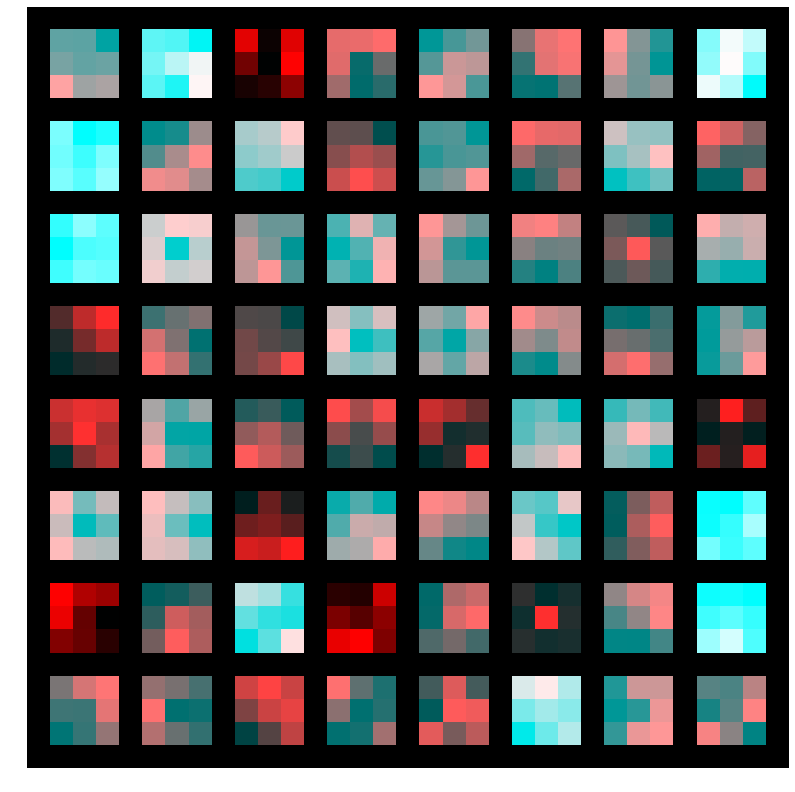

In [46]:
viz_filters(model_aug.net._modules['conv1']._modules['original_conv1'])

## new (RGB) conv layer

In [85]:
isinstance(nn.Sequential(), nn.Sequential)

# x = [nn.Identity(), nn.Identity(), nn.Sequential(
#    nn.Identity(),
#    nn.Identity(),
#  )]

# # import itertools

# list(itertools.chain(*[list(l) if isinstance(l, torch.nn.modules.container.Sequential) else [l] for l in x]))
# # [list(l) if isinstance(l, torch.nn.modules.container.Sequential) else l for l in x]


True

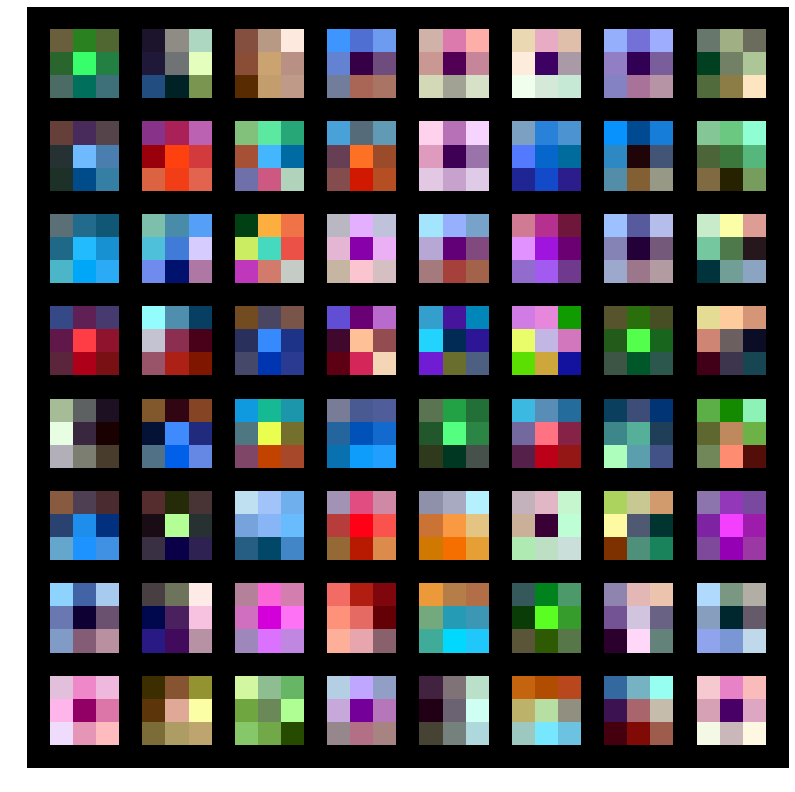

In [49]:
viz_filters(model_aug.net._modules['conv1']._modules['new_conv1'])

## Visualize 1x1 conv layer filters

Each of the 64 conv kernels in the 1x1 layer is a 1x1x128 tensor. We can visualize them all at once by reshaping them into a 64x128 matrix.

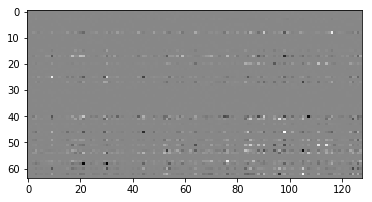

In [48]:
plt.imshow(model_aug.net._modules['conv1'].after[2].weight.data.squeeze().detach().cpu(), cmap='gray')
plt.show()

## Visualize outputs of all intermediate conv layers


------------------------------------------- Input image -------------------------------------------



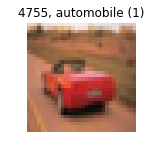

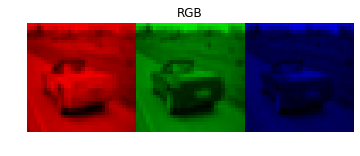


------------------------------------------- Model predictions -------------------------------------------

Predicted class probabilities: tensor([1.7306e-06, 9.9996e-01, 4.4016e-07, 9.0196e-06, 2.3381e-07, 3.0362e-06,
        3.1326e-06, 4.7523e-07, 2.3930e-06, 2.0422e-05])


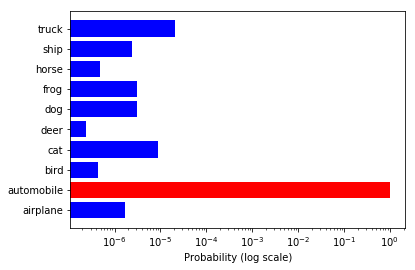


------------------------------------------- Layer-wise output -------------------------------------------

Layer: ModifiedConv1(
  (original_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (new_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (after): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)
Output shape: torch.Size([64, 1, 32, 32])


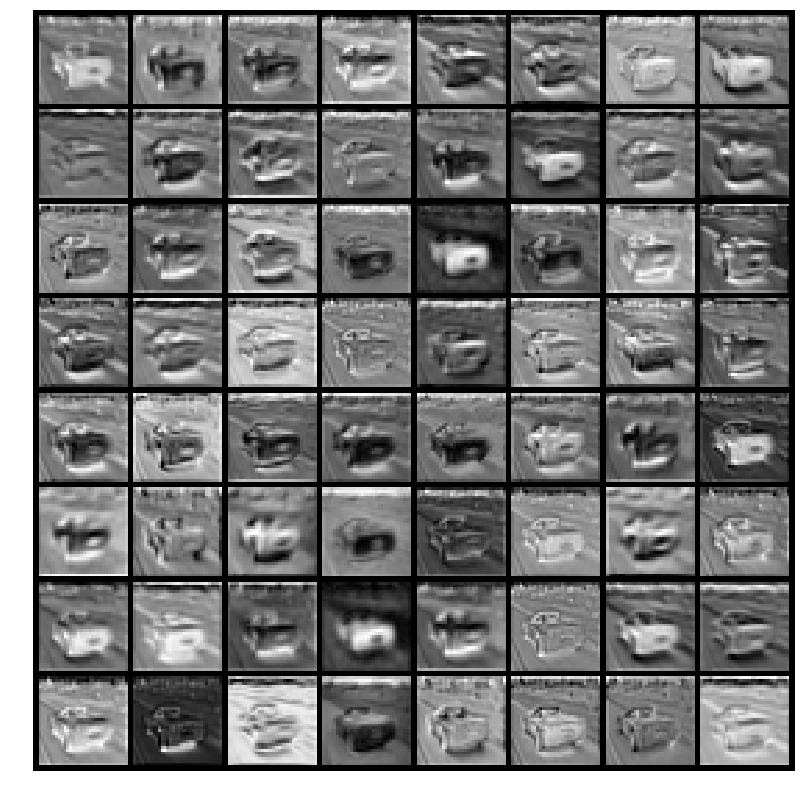

Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([64, 1, 32, 32])


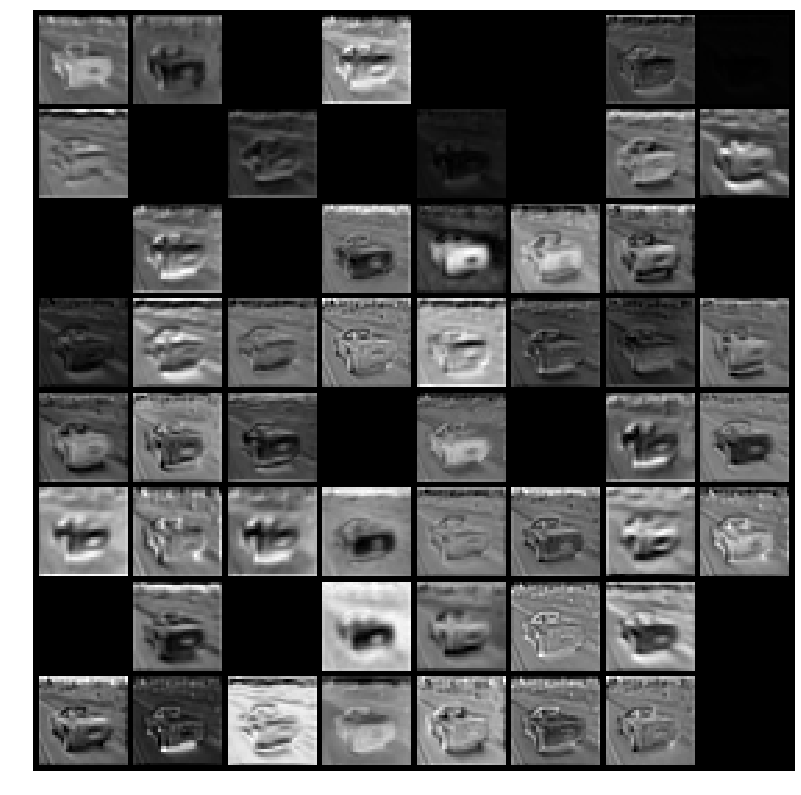

Layer: ReLU(inplace)
Output shape: torch.Size([64, 1, 32, 32])


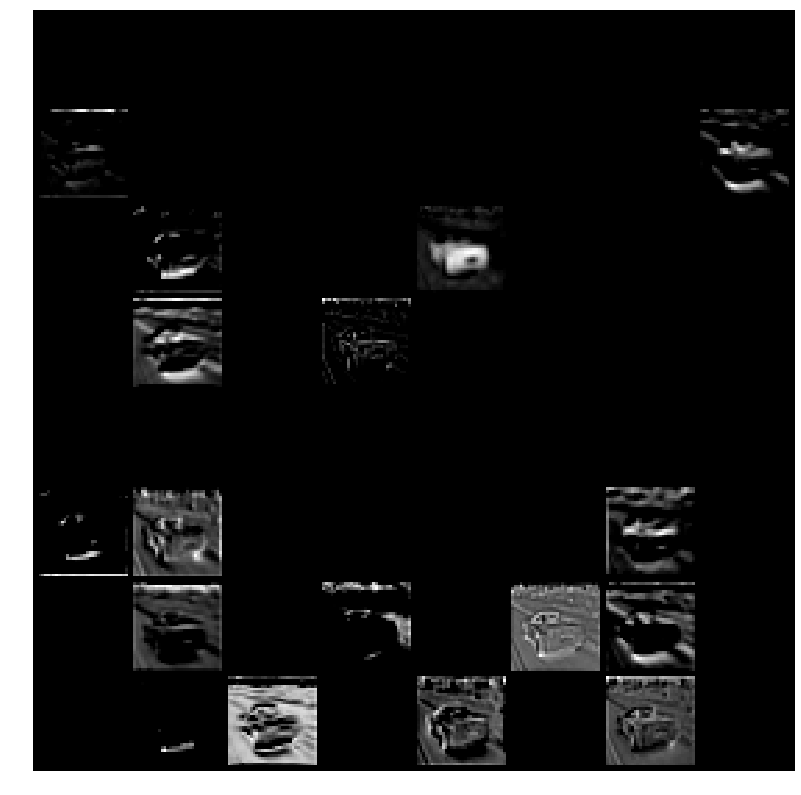

Layer: Identity()
Output shape: torch.Size([64, 1, 32, 32])


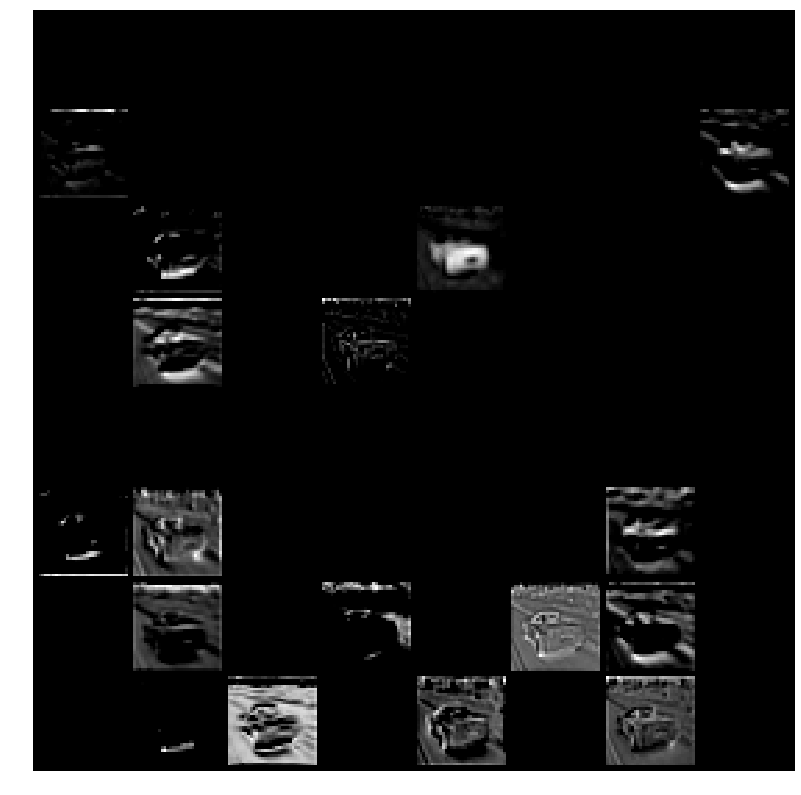

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Output shape: torch.Size([64, 1, 32, 32])


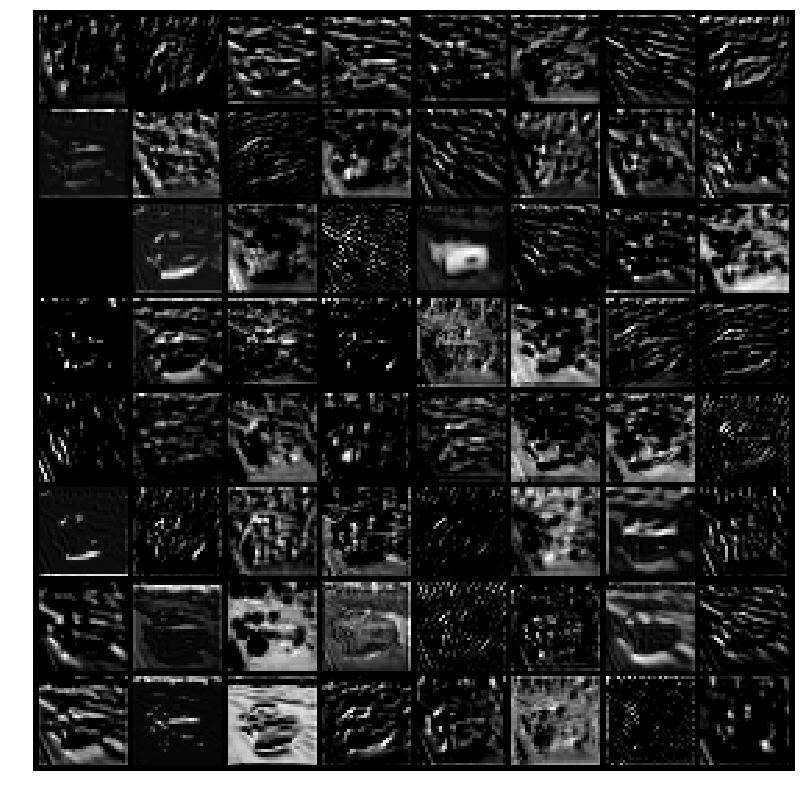

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05,

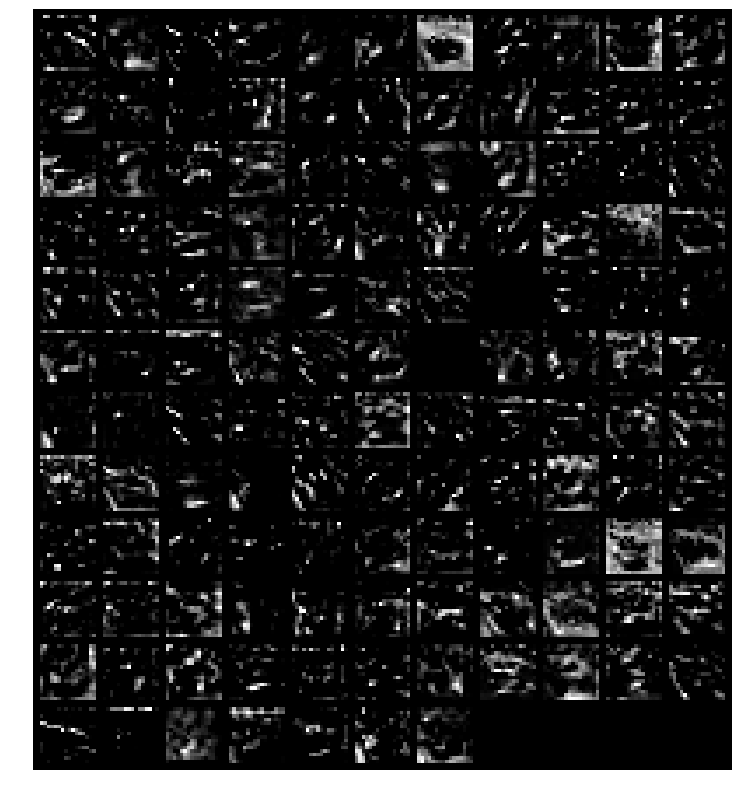

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-0

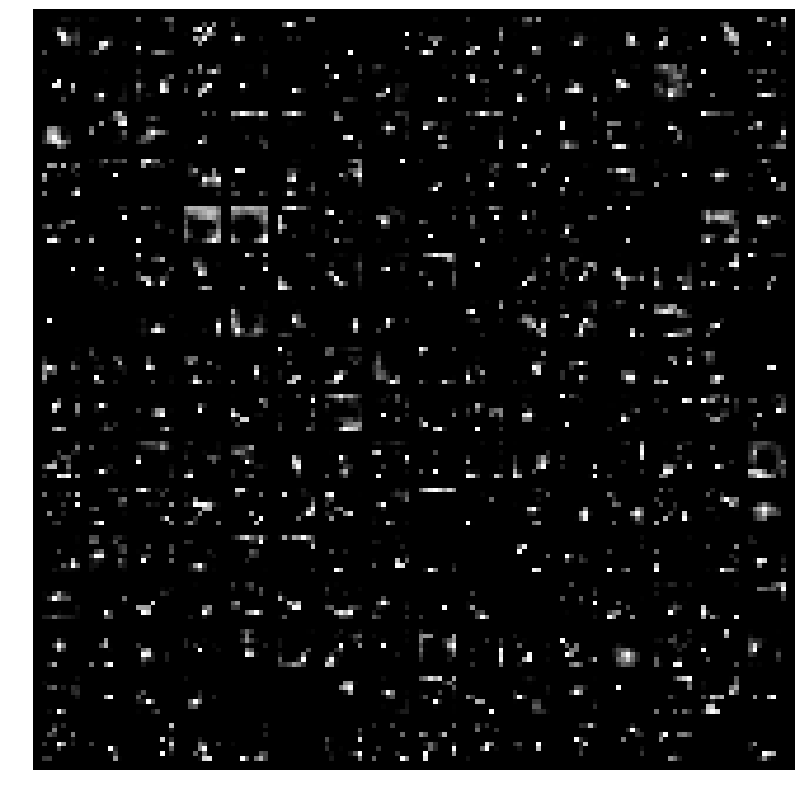

Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-0

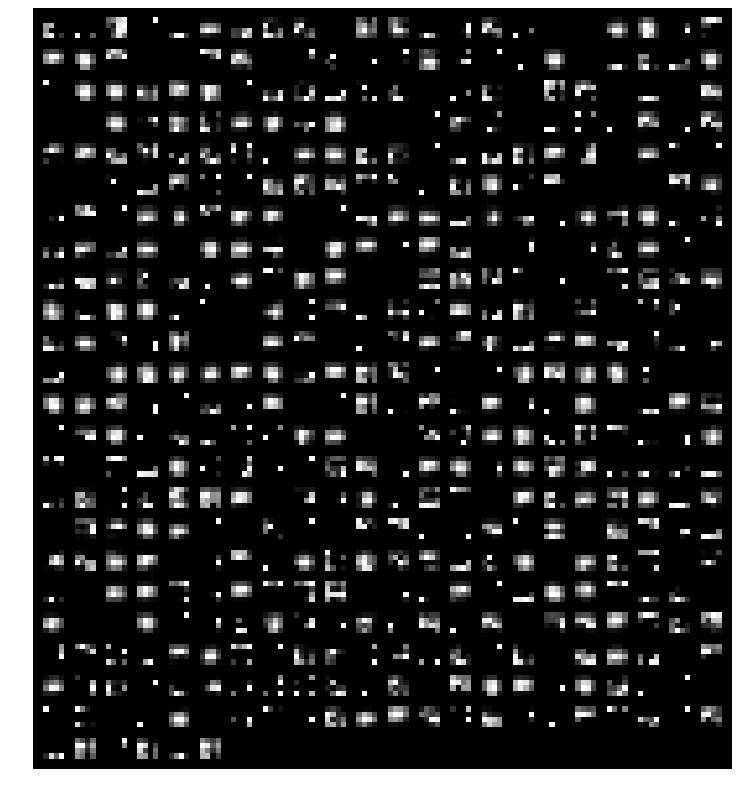

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Layer: AdaptiveAvgPool2d(output_size=(1, 1))
Output shape: torch.Size([512, 1, 1, 1])


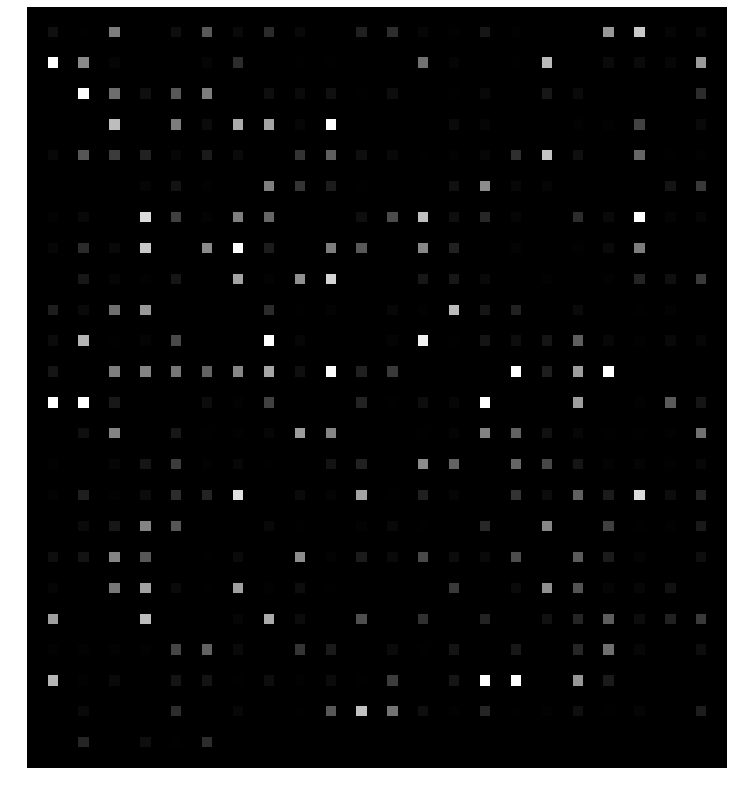

In [100]:
idx = int(torch.rand(1) * len(val))
model_debug(model_aug, idx)

# Random stuff

In [0]:
model_aug.net._modules['conv1']._modules['new_conv1'].weight.data = model_aug.net._modules['conv1']._modules['original_conv1'].weight.data.clone()

In [0]:
# model_aug.net._modules['conv1']._modules['after'][-1].weight.data = torch.eye(64).repeat((1, 2)).unsqueeze(-1).unsqueeze(-1).cuda() * 0.5 + .2
model_aug.net._modules['conv1']._modules['after'][-1].weight.data

In [94]:
[x.abs().mean() for x in model_aug.net._modules['conv1']._modules['original_conv1'].weight.data.permute(1, 0, 2, 3)],[x.abs().mean() for x in model_aug.net._modules['conv1']._modules['new_conv1'].weight.data.permute(1, 0, 2, 3)]

([tensor(0.1357, device='cuda:0'),
  tensor(1.3378e-12, device='cuda:0'),
  tensor(1.2937e-12, device='cuda:0')],
 [tensor(0.0354, device='cuda:0'),
  tensor(0.0417, device='cuda:0'),
  tensor(0.0396, device='cuda:0')])

In [0]:
model_aug.net._modules['conv1']._modules['new_conv1'].weight.data[:, 1, :, :] = model_aug.net._modules['conv1']._modules['new_conv1'].weight.data[:, 0, :, :].clone()
model_aug.net._modules['conv1']._modules['new_conv1'].weight.data[:, 2, :, :] = model_aug.net._modules['conv1']._modules['new_conv1'].weight.data[:, 0, :, :].clone()